In [71]:
import os
import numpy as np
import torch
import random
import cv2
import matplotlib.pyplot as plt
import yaml

In [83]:
CONFIG = {
    "data_path": "/Users/waritboonmasiri/Work/01_Personal/temp/jupyter-vscode/pavement/v1",
    "output_root": "/Users/waritboonmasiri/Work/04_UTS/Deep learning/assignment3/pavement/output",
    "seed": 42,
    "batch_size": 10,
}

In [4]:
random.seed(CONFIG["seed"])
torch.manual_seed(CONFIG["seed"])
np.random.seed(CONFIG["seed"])

In [13]:
for folder in os.listdir(CONFIG["data_path"]):
    print(folder)
    for file in os.listdir(os.path.join(CONFIG["data_path"], folder)):
        abs_path = os.path.join(CONFIG["data_path"], folder, file)
        if os.path.isfile(abs_path):
            print(abs_path)
            # break
    break

1055466_DF_020_020BDF0070_09001
/Users/waritboonmasiri/Work/01_Personal/temp/jupyter-vscode/pavement/v1/1055466_DF_020_020BDF0070_09001/1055466_DF_020_020BDF0070_09001_RAW.jpg
/Users/waritboonmasiri/Work/01_Personal/temp/jupyter-vscode/pavement/v1/1055466_DF_020_020BDF0070_09001/1055466_DF_020_020BDF0070_09001_POTHOLE.png
/Users/waritboonmasiri/Work/01_Personal/temp/jupyter-vscode/pavement/v1/1055466_DF_020_020BDF0070_09001/1055466_DF_020_020BDF0070_09001_LANE.png
/Users/waritboonmasiri/Work/01_Personal/temp/jupyter-vscode/pavement/v1/1055466_DF_020_020BDF0070_09001/1055466_DF_020_020BDF0070_09001_CRACK.png


In [87]:
CLASS_MAP = {
    'POTHOLE': 0,
    'CRACK': 1,
    # 'LANE': 2,
    # Add more classes if needed
}

CLASS_NAMES = {0: "POTHOLE", 1: "CRACK", 2: "LANE"}


In [56]:
import cv2
import numpy as np

def mask_to_yolo_segmentation(mask_path, is_demo=False):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        return []  # no polygons if mask not found
    
    # Threshold in case mask is not strictly 0/255
    _, thresh = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    
    # Find external contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    h, w = mask.shape[:2]
    polygons = []
    for cnt in contours:
        # If you want to reduce the number of points, you can approximate the contour:
        # cnt = cv2.approxPolyDP(cnt, epsilon=2.0, closed=True)
        
        # Flatten contour to a list of (x, y) points
        cnt = cnt.reshape(-1, 2)
        
        # Normalize
        normalized = []
        for (px, py) in cnt:
            nx = px / w
            ny = py / h
            normalized.extend([nx, ny])  # [x1, y1, x2, y2, ...]
        
        # Skip polygons with very few points, if desired
        if len(normalized) >= 6:  # (x1,y1),(x2,y2),(x3,y3) => at least 3 points
            polygons.append(normalized)
    if is_demo:
        return polygons, (w, h)
    return polygons


In [57]:
def get_sample_path(idx):
    files = []
    folder =  os.listdir(CONFIG["data_path"])[idx]
    for file in os.listdir(os.path.join(CONFIG["data_path"], folder)):
        abs_path = os.path.join(CONFIG["data_path"], folder, file)
        if os.path.isfile(abs_path):
            files.append(abs_path)
    return files


In [58]:
sample_paths = get_sample_path(10)
sample_paths

['/Users/waritboonmasiri/Work/01_Personal/temp/jupyter-vscode/pavement/v1/917038_RS_290_290RS294095_18640/917038_RS_290_290RS294095_18640_POTHOLE.png',
 '/Users/waritboonmasiri/Work/01_Personal/temp/jupyter-vscode/pavement/v1/917038_RS_290_290RS294095_18640/917038_RS_290_290RS294095_18640_RAW.jpg',
 '/Users/waritboonmasiri/Work/01_Personal/temp/jupyter-vscode/pavement/v1/917038_RS_290_290RS294095_18640/917038_RS_290_290RS294095_18640_LANE.png',
 '/Users/waritboonmasiri/Work/01_Personal/temp/jupyter-vscode/pavement/v1/917038_RS_290_290RS294095_18640/917038_RS_290_290RS294095_18640_CRACK.png']

In [59]:
import matplotlib.image as mpimg

class DataPoint:
    def __init__(self, raw: np.ndarray, crack: np.ndarray, lane: np.ndarray, pothole: np.ndarray):
        self.raw = raw
        self.crack = crack
        self.lane = lane
        self.pothole = pothole

    def __repr__(self):
        return f"DataPoint(raw={self.raw.shape}, crack={self.crack.shape}, lane={self.lane.shape}, pothole={self.pothole.shape})"

    def all(self):
        return [self.raw, self.crack, self.lane, self.pothole]

def suffix_path(folder_path: str, suffix: str) -> str:
    sample_path = folder_path.split('/')[-1]
    return "/".join([folder_path, sample_path + "_{suffix}".format(suffix=suffix)])

def raw_path(folder_path: str) -> str:
    return suffix_path(folder_path, 'RAW.jpg')

def crack_path(folder_path: str) -> str:
    return suffix_path(folder_path, 'CRACK.png')

def lane_path(folder_path: str) -> str:
    return suffix_path(folder_path, 'LANE.png')

def pothole_path(folder_path: str) -> str:
    return suffix_path(folder_path, 'POTHOLE.png')

def imgs_by_folder(folder_path: str) -> DataPoint:
    return DataPoint(
        raw= mpimg.imread(raw_path(folder_path)),
        crack= mpimg.imread(crack_path(folder_path)),
        lane= mpimg.imread(lane_path(folder_path)),
        pothole= mpimg.imread(pothole_path(folder_path))
    )

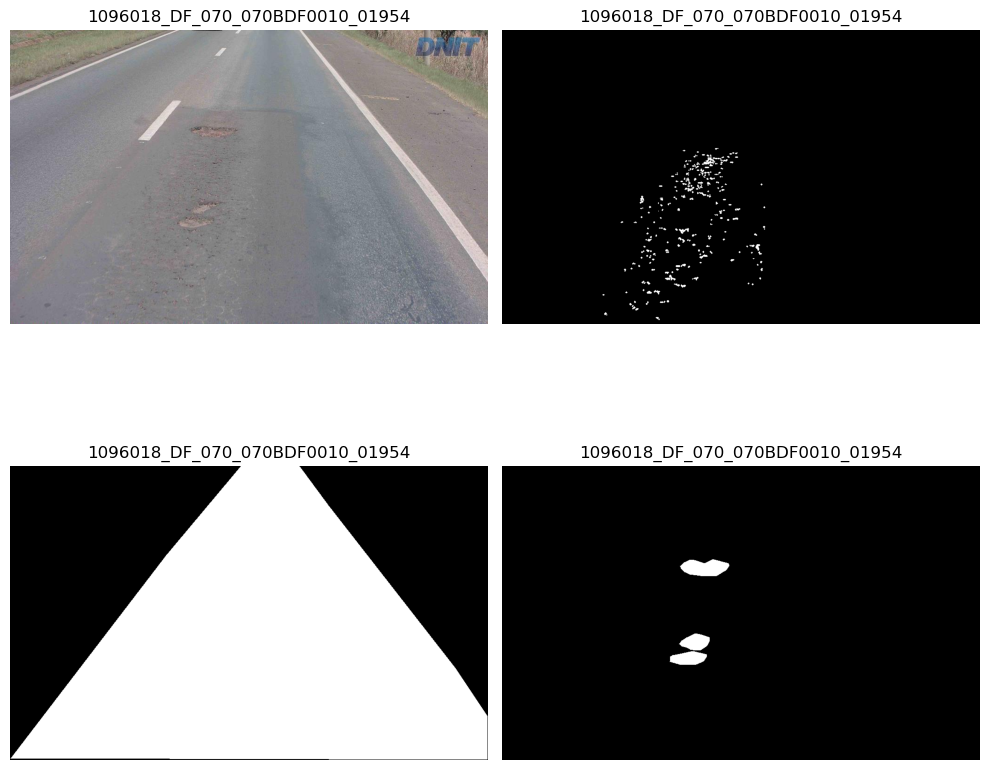

In [60]:
sample_folder = '1096018_DF_070_070BDF0010_01954'

imgs_sample = imgs_by_folder("/".join([CONFIG['data_path'], sample_folder]))

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes = axes.flatten()

for ax, img in zip(axes, imgs_sample.all()[:4]):
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(sample_folder.split('/')[-1])

plt.tight_layout()
plt.show()

In [91]:
imgs_sample.raw.shape

(630, 1024, 3)

In [61]:
def check_polygon(mask_path):
    polygons, (w, h) = mask_to_yolo_segmentation(mask_path, is_demo=True)
    
    # Load the original mask (for display purposes)
    mask_image = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    # Create a color version of the mask image to overlay polygons
    mask_with_polygons = cv2.cvtColor(mask_image, cv2.COLOR_GRAY2BGR)
    
    
    # Draw each polygon on the mask copy
    for poly in polygons:
        # Reshape list to array of (x, y)
        poly_arr = np.array(poly).reshape(-1, 2)
        # Convert normalized coordinates back to pixel coordinates
        poly_arr[:, 0] = poly_arr[:, 0] * w
        poly_arr[:, 1] = poly_arr[:, 1] * h
        poly_arr = poly_arr.astype(np.int32)
        
        # Draw the polygon with red outline (BGR: (0, 0, 255))
        cv2.polylines(mask_with_polygons, [poly_arr], isClosed=True, color=(0, 0, 255), thickness=2)
    
    # Plot side by side using Matplotlib
    plt.figure(figsize=(12, 6))
    
    # Left: Original mask (grayscale)
    plt.subplot(1, 2, 1)
    plt.imshow(mask_image, cmap='gray')
    plt.title("Original Mask")
    plt.axis("off")
    
    # Right: Mask with extracted polygons overlaid
    plt.subplot(1, 2, 2)
    # Convert BGR to RGB for matplotlib
    mask_with_polygons_rgb = cv2.cvtColor(mask_with_polygons, cv2.COLOR_BGR2RGB)
    plt.imshow(mask_with_polygons_rgb)
    plt.title("Extracted Polygons (mask_to_yolo_segmentation)")
    plt.axis("off")
    
    plt.tight_layout()
    plt.show()

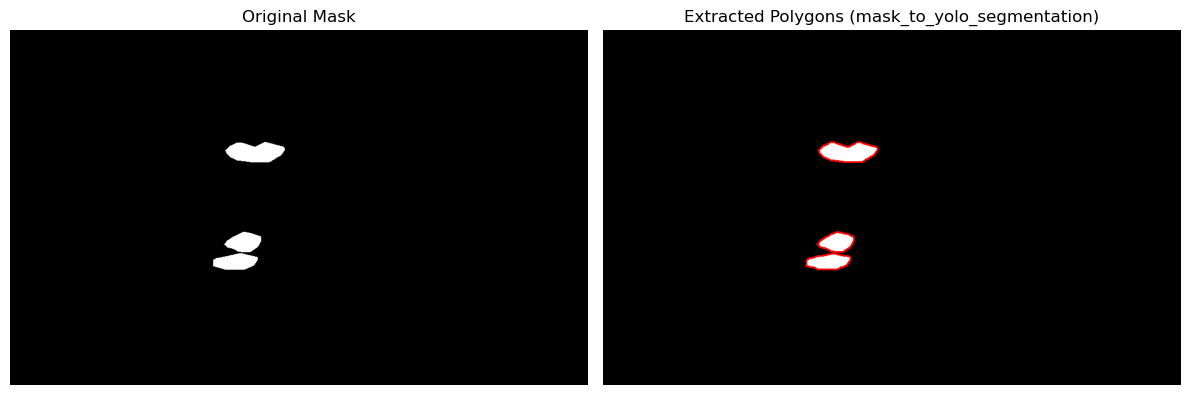

In [62]:
check_polygon("/".join([CONFIG["data_path"] , pothole_path(sample_folder)]))

In [76]:
import os
import shutil
from tqdm import tqdm

def build_yolo_segmentation_dataset(data_root, output_root, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1):
    
    if abs(train_ratio + val_ratio + test_ratio - 1.0) > 1e-6:
        raise ValueError("Train, val, and test ratios must sum to 1")
    
    # Create the output directories for images and labels for each split.
    splits = ['train', 'val', 'test']
    for split in splits:
        os.makedirs(os.path.join(output_root, "images", split), exist_ok=True)
        os.makedirs(os.path.join(output_root, "labels", split), exist_ok=True)
    
    def extract_class_id(filename):
        """
        Returns the class ID based on a keyword match in the filename.
        The keyword (e.g., 'POTHOLE') must appear in the file name (case-insensitive).
        """
        for keyword, class_id in CLASS_MAP.items():
            if keyword in filename.upper():
                return class_id
        return None

    def mask_to_yolo_segmentation(mask_path):
        """
        Reads a binary mask image from `mask_path` (expects a single-channel mask)
        and returns a list of polygon annotations with normalized coordinates.
        
        Each polygon is represented as a list:
            [x1_norm, y1_norm, x2_norm, y2_norm, ..., xN_norm, yN_norm]
        
        Only contours with at least 3 points (6 numbers) are returned.
        """
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            return []
        # Threshold in case the mask isn't strictly 0/255.
        _, thresh = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        h, w = mask.shape[:2]
        polygons = []
        for cnt in contours:
            cnt = cnt.reshape(-1, 2)
            normalized = []
            for (px, py) in cnt:
                normalized.extend([px / w, py / h])
            if len(normalized) >= 6:
                polygons.append(normalized)
        return polygons

    # List all sample folders from data_root.
    sample_folders = [folder for folder in os.listdir(data_root) if os.path.isdir(os.path.join(data_root, folder))]
    random.shuffle(sample_folders)
    
    total_samples = len(sample_folders)
    num_train = int(total_samples * train_ratio)
    num_val = int(total_samples * val_ratio)
    # The remaining samples will be assigned to the test split.
    num_test = total_samples - num_train - num_val
    
    train_samples = sample_folders[:num_train]
    val_samples = sample_folders[num_train:num_train + num_val]
    test_samples = sample_folders[num_train + num_val:]
    
    def process_sample(folder, split):
        """
        Processes a single sample folder:
          - Finds the raw image (must contain "RAW" in the filename)
          - Collects mask images (PNG files not marked as RAW)
          - Copies the raw image to the split folder and writes the label file.
        """
        folder_path = os.path.join(data_root, folder)
        raw_image_path = None
        mask_paths = []
        
        for filename in os.listdir(folder_path):
            abs_path = os.path.join(folder_path, filename)
            if os.path.isfile(abs_path):
                # Check for raw image (assumed to have "RAW" in the name and an accepted extension)
                if "RAW" in filename.upper() and filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                    raw_image_path = abs_path
                else:
                    # Assume mask files are PNG images.
                    if filename.lower().endswith('.png'):
                        mask_paths.append(abs_path)
        
        if raw_image_path is None:
            print(f"Skipping folder {folder}: no RAW image found.")
            return
        
        # Prepare the output filename (keep the same base name).
        base_name = os.path.basename(raw_image_path)
        new_image_name = base_name
        out_image_path = os.path.join(output_root, "images", split, new_image_name)
        shutil.copy(raw_image_path, out_image_path)
        
        # Build the label file name.
        label_file_name = os.path.splitext(new_image_name)[0] + ".txt"
        out_label_path = os.path.join(output_root, "labels", split, label_file_name)
        
        lines_to_write = []
        for mask_path in mask_paths:
            class_id = extract_class_id(mask_path)
            if class_id is None:
                continue  # Skip unrecognized mask files.
            polygons = mask_to_yolo_segmentation(mask_path)
            for poly in polygons:
                poly_str = " ".join([f"{p:.6f}" for p in poly])
                line = f"{class_id} {poly_str}"
                lines_to_write.append(line)
        
        with open(out_label_path, 'w') as f:
            f.write("\n".join(lines_to_write))
    
    # Process all samples for each split.
    for folder in tqdm(train_samples):
        process_sample(folder, "train")
    for folder in tqdm(val_samples):
        process_sample(folder, "val")
    for folder in tqdm(test_samples):
        process_sample(folder, "test")
    
    print(f"Processed {len(train_samples)} training, {len(val_samples)} validation, and {len(test_samples)} test samples.")
    
    write_yolo_yaml(output_root, CLASS_MAP)
    print(f"Done write yaml")
    

def write_yolo_yaml(output_root, class_map, train_dir='images/train', val_dir='images/val', test_dir='images/test'):
    # Flip the class_map so that keys are integers and values are class names.
    flipped = {v: k for k, v in class_map.items()}
    
    yaml_data = {
        'path': output_root,
        'train': train_dir,
        'val': val_dir,
        'names': flipped
    }
    
    # Optionally, include test path if the directory exists and is non-empty.
    test_path = os.path.join(output_root, test_dir)
    if os.path.exists(test_path) and os.listdir(test_path):
        yaml_data['test'] = test_dir
    
    yaml_path = os.path.join(output_root, "dataset.yaml")
    with open(yaml_path, "w") as f:
        yaml.dump(yaml_data, f, default_flow_style=False)
    print(f"YOLO YAML file written to: {yaml_path}")


In [77]:
build_yolo_segmentation_dataset(
    data_root=CONFIG['data_path'],
    output_root=CONFIG['output_root'],
    train_ratio=0.7,
    val_ratio=0.2,
    test_ratio=0.1,
)

100%|██████████| 224/224 [00:05<00:00, 43.28it/s]

Processed 1564 training, 447 validation, and 224 test samples.
YOLO YAML file written to: /Users/waritboonmasiri/Work/04_UTS/Deep learning/assignment3/pavement/output2/dataset.yaml
Done write yaml


In [79]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
    
def check_process_data(image_path, label_path):
    # Define class names (if needed) and assign distinct BGR colors for visualization.
    CLASS_COLOR = {
        0: (0, 0, 255),  # Red for POTHOLE
        1: (0, 255, 0),  # Green for CRACK
        2: (255, 0, 0)   # Blue for LANE
    }
    
    raw_image = cv2.imread(image_path)
    if raw_image is None:
        raise ValueError(f"Cannot load image from: {image_path}")
    h, w, _ = raw_image.shape
    
    # Create a copy for drawing segmentation polygons.
    annotated_image = raw_image.copy()
    
    with open(label_path, 'r') as f:
        lines = f.read().strip().splitlines()
    
    for line in lines:
        # Each line: "class_id x1 y1 x2 y2 ... xN yN"
        parts = line.strip().split()
        class_id = int(parts[0])
        # Convert the remaining parts to float (normalized coordinates)
        coords = list(map(float, parts[1:]))
        
        # Convert normalized coordinates back to pixel coordinates.
        points = []
        for i in range(0, len(coords), 2):
            x_norm = coords[i]
            y_norm = coords[i+1]
            x_pixel = int(x_norm * w)
            y_pixel = int(y_norm * h)
            points.append([x_pixel, y_pixel])
        
        points = np.array(points, dtype=np.int32)
        points = points.reshape((-1, 1, 2))
        
        # Choose color based on class_id or default to white if not found.
        color = CLASS_COLOR.get(class_id, (255, 255, 255))
        
        # Draw polygon outline. You can also fill the polygon if desired.
        cv2.polylines(annotated_image, [points], isClosed=True, color=color, thickness=2)
        
        # Optionally, add a text label at the first vertex of the polygon.
        if points.size > 0:
            cv2.putText(annotated_image,
                        CLASS_NAMES.get(class_id, str(class_id)),
                        (points[0][0][0], points[0][0][1] - 5), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, thickness=1)
    
    # -----------------------
    # Plot side by side using matplotlib
    # -----------------------
    plt.figure(figsize=(12, 6))
    
    # Left: Raw image
    plt.subplot(1, 2, 1)
    # Convert image from BGR (OpenCV) to RGB for displaying with matplotlib.
    plt.imshow(cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB))
    plt.title("Raw Image")
    plt.axis("off")
    
    # Right: Raw image with overlaid segmentation polygons from label file.
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
    plt.title("Raw Image with YOLO Segmentation Labels")
    plt.axis("off")
    
    plt.tight_layout()
    plt.show()

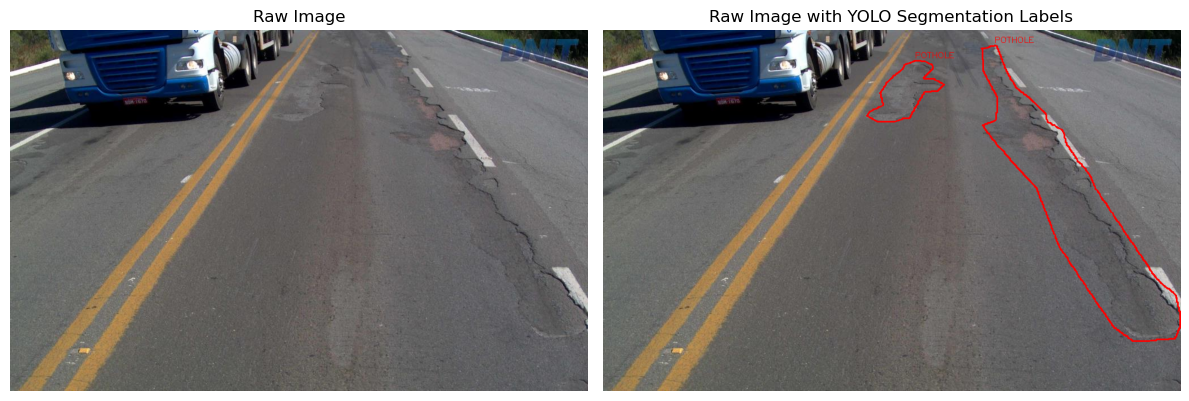

In [89]:
check_process_data(
    CONFIG['output_root'] + "/images/train/" + '883078_RS_290_290RS150131_16121_RAW.jpg', 
    CONFIG['output_root'] + "/labels/train/" + '883078_RS_290_290RS150131_16121_RAW.txt'
)

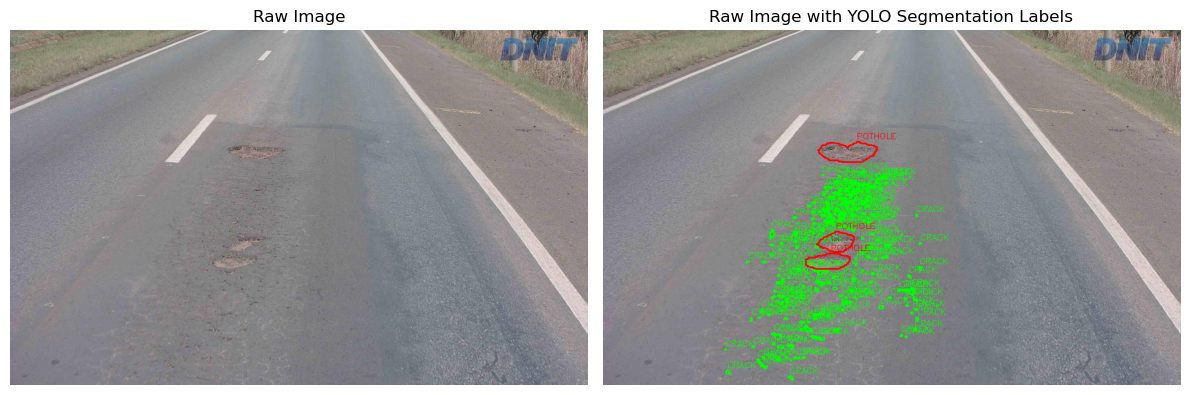

In [90]:
check_process_data(
    CONFIG['output_root'] + "/images/train/" + '1096018_DF_070_070BDF0010_01954_RAW.jpg', 
    CONFIG['output_root'] + "/labels/train/" + '1096018_DF_070_070BDF0010_01954_RAW.txt'
)